# Vaccine tweets - processing and exploration

In [64]:
# Required Libraries

#Base and Cleaning 
import json
import requests
import pandas as pd
import numpy as np
import emoji
import regex
import re
import string
from collections import Counter

#Visualizations
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis.gensim
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls

#Natural Language Processing (NLP)
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

# custom functions and reload after editing
from functions import *
%load_ext autoreload
%autoreload 2

/Users/ariadnavargas/anaconda3/lib/python3.7/site-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [2]:
# load file
tweets = pd.read_csv('tweets_clean_normalized.csv', index_col=0)

# check shape
tweets.shape

(415228, 8)

In [3]:
tweets.isna().sum()

date                0
year                0
month               0
month_year          0
tweet               0
sentiment_score     0
sentiment           0
tweet_clean        10
dtype: int64

In [4]:
tweets.head()

,date,year,month,month_year,tweet,sentiment_score,sentiment,tweet_clean
0,2021-01-03,2021,1,2021-01,@TheMossadIL @JoBiGutenburg02 @guardian Here w...,-0.7717,negative,themossadil jobigutenburg guardian go usual re...
1,2021-01-03,2021,1,2021-01,A friend of mine got her Mederna vaccine last ...,-0.5267,negative,friend mine get mederna vaccine last thursday ...
2,2021-01-03,2021,1,2021-01,@BeschlossDC @redtaz1951 Trump never cared abo...,0.8614,positive,beschlossdc redtaz trump never care democracy ...
3,2021-01-03,2021,1,2021-01,@kristie_lauraaa @TTamharl We have never had a...,-0.6722,negative,kristie_lauraaa ttamharl never flu vaccine sho...
4,2021-01-03,2021,1,2021-01,Tennessee officials give COVID vaccine to 'clo...,0.1779,positive,tennessee official give covid vaccine close fa...


## Data cleaning

In [5]:
tweets_clean = tweets.copy()

In [6]:
# Remove emoji's from tweets
def give_emoji_free_text(text):
    emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

# Clean text from urls
def url_free_text(text):
    try:
        text = re.sub(r'http\S+', '', text)
        return text
    except:
        text=text
        return text

# Apply the function above and get tweets free of emoji's
call_emoji_free = lambda x: give_emoji_free_text(x)

# Apply `call_emoji_free` which calls the function to remove all emoji's
tweets_clean['tweet_emoji_free'] = tweets_clean['tweet'].apply(call_emoji_free)

#Create a new column with url free tweets

tweets_clean['tweet_url_free'] = tweets_clean['tweet_emoji_free'].apply(url_free_text)


In [7]:
tweets_clean

,date,year,month,month_year,tweet,sentiment_score,sentiment,tweet_clean,tweet_emoji_free,tweet_url_free
0,2021-01-03,2021,1,2021-01,@TheMossadIL @JoBiGutenburg02 @guardian Here w...,-0.7717,negative,themossadil jobigutenburg guardian go usual re...,@TheMossadIL @JoBiGutenburg02 @guardian Here w...,@TheMossadIL @JoBiGutenburg02 @guardian Here w...
1,2021-01-03,2021,1,2021-01,A friend of mine got her Mederna vaccine last ...,-0.5267,negative,friend mine get mederna vaccine last thursday ...,A friend of mine got her Mederna vaccine last ...,A friend of mine got her Mederna vaccine last ...
2,2021-01-03,2021,1,2021-01,@BeschlossDC @redtaz1951 Trump never cared abo...,0.8614,positive,beschlossdc redtaz trump never care democracy ...,@BeschlossDC @redtaz1951 Trump never cared abo...,@BeschlossDC @redtaz1951 Trump never cared abo...
3,2021-01-03,2021,1,2021-01,@kristie_lauraaa @TTamharl We have never had a...,-0.6722,negative,kristie_lauraaa ttamharl never flu vaccine sho...,@kristie_lauraaa @TTamharl We have never had a...,@kristie_lauraaa @TTamharl We have never had a...
4,2021-01-03,2021,1,2021-01,Tennessee officials give COVID vaccine to 'clo...,0.1779,positive,tennessee official give covid vaccine close fa...,Tennessee officials give COVID vaccine to 'clo...,Tennessee officials give COVID vaccine to 'clo...
5,2021-01-03,2021,1,2021-01,@sdr_medco @RENEEWEATHERS2 When that 40% gets ...,0.0000,neutral,sdr_medco reneeweathers get start take need ma...,@sdr_medco @RENEEWEATHERS2 When that 40% gets ...,@sdr_medco @RENEEWEATHERS2 When that 40% gets ...
6,2021-01-03,2021,1,2021-01,@Chizack @Scripteladora @DanielD86829949 @P3ng...,-0.8885,negative,chizack scripteladora danield p ng z hebmacman...,@Chizack @Scripteladora @DanielD86829949 @P3ng...,@Chizack @Scripteladora @DanielD86829949 @P3ng...
7,2021-01-03,2021,1,2021-01,My dad got the Covid vaccine 🥴,0.0000,neutral,dad get covid vaccine,My dad got the Covid vaccine,My dad got the Covid vaccine
8,2021-01-03,2021,1,2021-01,@lelakis @degaeta I would hope she’s busy toda...,0.4404,positive,lelakis degaeta would hope busy today work dep...,@lelakis @degaeta I would hope she’s busy toda...,@lelakis @degaeta I would hope she’s busy toda...
9,2021-01-03,2021,1,2021-01,"@gabydvj the genius of sandwiching ""I'm not ta...",0.0000,neutral,gabydvj genius sandwich not take covid vaccine...,"@gabydvj the genius of sandwiching ""I'm not ta...","@gabydvj the genius of sandwiching ""I'm not ta..."


## Data pre-processing

##### Tokenization

In [8]:

# Load spacy
# Make sure to restart the runtime after running installations and libraries tab
nlp = spacy.load('en_core_web_lg')

In [9]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(tweets_clean['tweet_url_free'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
tweets_clean['tokens'] = tokens

In [10]:
tweets_clean.head()

,date,year,month,month_year,tweet,sentiment_score,sentiment,tweet_clean,tweet_emoji_free,tweet_url_free,tokens
0,2021-01-03,2021,1,2021-01,@TheMossadIL @JoBiGutenburg02 @guardian Here w...,-0.7717,negative,themossadil jobigutenburg guardian go usual re...,@TheMossadIL @JoBiGutenburg02 @guardian Here w...,@TheMossadIL @JoBiGutenburg02 @guardian Here w...,"[@themossadil, @jobigutenburg02, @guardian, us..."
1,2021-01-03,2021,1,2021-01,A friend of mine got her Mederna vaccine last ...,-0.5267,negative,friend mine get mederna vaccine last thursday ...,A friend of mine got her Mederna vaccine last ...,A friend of mine got her Mederna vaccine last ...,"[friend, mederna, vaccine, thursday., sore, ar..."
2,2021-01-03,2021,1,2021-01,@BeschlossDC @redtaz1951 Trump never cared abo...,0.8614,positive,beschlossdc redtaz trump never care democracy ...,@BeschlossDC @redtaz1951 Trump never cared abo...,@BeschlossDC @redtaz1951 Trump never cared abo...,"[@beschlossdc, @redtaz1951, trump, cared, demo..."
3,2021-01-03,2021,1,2021-01,@kristie_lauraaa @TTamharl We have never had a...,-0.6722,negative,kristie_lauraaa ttamharl never flu vaccine sho...,@kristie_lauraaa @TTamharl We have never had a...,@kristie_lauraaa @TTamharl We have never had a...,"[@kristie_lauraaa, @ttamharl, flu, vaccine., s..."
4,2021-01-03,2021,1,2021-01,Tennessee officials give COVID vaccine to 'clo...,0.1779,positive,tennessee official give covid vaccine close fa...,Tennessee officials give COVID vaccine to 'clo...,Tennessee officials give COVID vaccine to 'clo...,"[tennessee, officials, covid, vaccine, 'close,..."


##### Lemmatization

In [11]:
# Make tokens a string again
tweets_clean['tokens_back_to_text'] = [' '.join(map(str, l)) for l in tweets_clean['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

tweets_clean['lemmas'] = tweets_clean['tokens_back_to_text'].apply(get_lemmas)

In [14]:
# Make lemmas a string again
tweets_clean['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in tweets_clean['lemmas']]

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
tweets_clean['lemma_tokens'] = tweets_clean['lemmas_back_to_text'].apply(tokenize)

<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:20: DeprecationWarning: invalid escape sequence \$
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:20: DeprecationWarning: invalid escape sequence \$
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:20: DeprecationWarning: invalid escape sequence \$
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:20: DeprecationWarning: invalid escape sequence \$
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:20: DeprecationWarning: invalid escape sequence \$
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:20: DeprecationWarning: invalid escape sequence \$
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:20: DeprecationWarning: invalid escape sequence 

In [15]:
tweets_clean.head()

,date,year,month,month_year,tweet,sentiment_score,sentiment,tweet_clean,tweet_emoji_free,tweet_url_free,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
0,2021-01-03,2021,1,2021-01,@TheMossadIL @JoBiGutenburg02 @guardian Here w...,-0.7717,negative,themossadil jobigutenburg guardian go usual re...,@TheMossadIL @JoBiGutenburg02 @guardian Here w...,@TheMossadIL @JoBiGutenburg02 @guardian Here w...,"[@themossadil, @jobigutenburg02, @guardian, us...",@themossadil @jobigutenburg02 @guardian usual ...,"[@themossadil, @jobigutenburg02, @guardian, us...",@themossadil @jobigutenburg02 @guardian usual ...,"[themossadil, jobigutenburg02, guardian, usual..."
1,2021-01-03,2021,1,2021-01,A friend of mine got her Mederna vaccine last ...,-0.5267,negative,friend mine get mederna vaccine last thursday ...,A friend of mine got her Mederna vaccine last ...,A friend of mine got her Mederna vaccine last ...,"[friend, mederna, vaccine, thursday., sore, ar...",friend mederna vaccine thursday. sore arm wors...,"[friend, mederna, vaccine, thursday, sore, arm...",friend mederna vaccine thursday sore arm bad t...,"[friend, mederna, vaccine, thursday, sore, arm..."
2,2021-01-03,2021,1,2021-01,@BeschlossDC @redtaz1951 Trump never cared abo...,0.8614,positive,beschlossdc redtaz trump never care democracy ...,@BeschlossDC @redtaz1951 Trump never cared abo...,@BeschlossDC @redtaz1951 Trump never cared abo...,"[@beschlossdc, @redtaz1951, trump, cared, demo...",@beschlossdc @redtaz1951 trump cared democracy...,"[@beschlossdc, @redtaz1951, trump, care, democ...",@beschlossdc @redtaz1951 trump care democracy ...,"[beschlossdc, redtaz1951, trump, care, democra..."
3,2021-01-03,2021,1,2021-01,@kristie_lauraaa @TTamharl We have never had a...,-0.6722,negative,kristie_lauraaa ttamharl never flu vaccine sho...,@kristie_lauraaa @TTamharl We have never had a...,@kristie_lauraaa @TTamharl We have never had a...,"[@kristie_lauraaa, @ttamharl, flu, vaccine., s...",@kristie_lauraaa @ttamharl flu vaccine. shot i...,"[@kristie_lauraaa, @ttamharl, flu, vaccine, sh...",@kristie_lauraaa @ttamharl flu vaccine shoot i...,"[kristie_lauraaa, ttamharl, flu, vaccine, shoo..."
4,2021-01-03,2021,1,2021-01,Tennessee officials give COVID vaccine to 'clo...,0.1779,positive,tennessee official give covid vaccine close fa...,Tennessee officials give COVID vaccine to 'clo...,Tennessee officials give COVID vaccine to 'clo...,"[tennessee, officials, covid, vaccine, 'close,...",tennessee officials covid vaccine 'close famil...,"[tennessee, official, covid, vaccine, close, f...",tennessee official covid vaccine close family ...,"[tennessee, official, covid, vaccine, close, f..."


## Topic modeling

##### Create base model

In [16]:
# Create a id2word dictionary
id2word = Dictionary(tweets_clean['lemma_tokens'])
print(len(id2word))

201559


In [17]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

70930


In [18]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in tweets_clean['lemma_tokens']]

In [40]:
# Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=20, id2word=id2word, workers=12, passes=50, iterations=50)

In [41]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

In [42]:
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

In [43]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
vaccine trump realdonaldtrump biden president election state say lie administration

------ Topic 1 ------
vaccine people go get covid know think take worry need

------ Topic 2 ------
vaccine pfizer covid-19 trial approve moderna fda uk effective use

------ Topic 3 ------
vaccine dose hospital pharmacist 500 wisconsin covid-19 intentionally destroy arrest

------ Topic 4 ------
crush speed warp operation joebiden kamalaharris vaccine pence racism kamala

------ Topic 5 ------
rollout new slow vaccine canada york cuomo ontario fordnation roll

------ Topic 6 ------
vaccine dose million 2 day 1 people need vaccinate administer

------ Topic 7 ------
vaccine covid19 today covid covid-19 question coronavirus morning covidvaccine update

------ Topic 8 ------
covid-19 warn organize crime threat vaccine romney mitt inexcusable slam

------ Topic 9 ------
vaccine covid month wait come year soon time go day

------ Topic 10 ------
vaccine distribution go interpol ny tim

In [44]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 


Perplexity:  -7.549453513407126


In [45]:
# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=tweets_clean['lemma_tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Coherence Score:  0.530635288798077


In [46]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(base_model, corpus, id2word)

/Users/ariadnavargas/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.139382 -0.146753       1        1  10.011634
1     -0.192404  0.018091       2        1   8.730172
12    -0.185362  0.044408       3        1   8.710762
0     -0.167551  0.047902       4        1   8.379997
9     -0.181409  0.033974       5        1   6.616724
16    -0.091633 -0.076096       6        1   6.059329
11    -0.171801  0.028833       7        1   5.822313
15    -0.142119  0.088977       8        1   5.608326
6     -0.113047  0.022236       9        1   5.608256
13     0.166721 -0.136794      10        1   4.968738
14    -0.110126  0.052376      11        1   4.748466
2     -0.001172 -0.128991      12        1   4.378488
7     -0.056286 -0.065727      13        1   4.315553
8      0.174263 -0.206691      14        1   3.822099
18     0.035920 -0.096644      15        1   2.494360
3      0.093731 -0.143959      16        1   2.490573
17     0.165431  0.121857      17        1   1.935997
19     0.217117  0.284893      18        1   1.918313
4      0.252524  0.140168      19        1   1.735694
5      0.167822  0.117940      20        1   1.644202, topic_info=      Category           Freq             Term          Total  loglift  \
323    Default   64261.000000     distribution   64261.000000  30.0000   
1300   Default   35830.000000            crush   35830.000000  29.0000   
9292   Default   57013.000000         interpol   57013.000000  28.0000   
972    Default   56888.000000               ny   56888.000000  27.0000   
2779   Default   56534.000000            times   56534.000000  26.0000   
2388   Default   56213.000000           slowly   56213.000000  25.0000   
2078   Default   56156.000000             mile   56156.000000  24.0000   
154    Default   75777.000000               go   75777.000000  23.0000   
257    Default   55156.000000         covid-19   55156.000000  22.0000   
759    Default   36485.000000             news   36485.000000  21.0000   
998    Default   34565.000000             home   34565.000000  20.0000   
1207   Default   33838.000000             stay   33838.000000  19.0000   
601    Default   31776.000000         positive   31776.000000  18.0000   
3327   Default   31546.000000            stock   31546.000000  17.0000   
1509   Default   28477.000000             warn   28477.000000  16.0000   
1553   Default   28034.000000         organize   28034.000000  15.0000   
2207   Default   27964.000000            crime   27964.000000  14.0000   
2441   Default   27961.000000           threat   27961.000000  13.0000   
15351  Default   30211.000000             zoom   30211.000000  12.0000   
48     Default   25589.000000            trump   25589.000000  11.0000   
52     Default   12456.000000              flu   12456.000000  10.0000   
61     Default   18740.000000             year   18740.000000   9.0000   
25     Default  443880.000000          vaccine  443880.000000   8.0000   
534    Default   14429.000000           pfizer   14429.000000   7.0000   
374    Default   17060.000000             dose   17060.000000   6.0000   
234    Default   14248.000000              new   14248.000000   5.0000   
677    Default   17438.000000            virus   17438.000000   4.0000   
475    Default   12951.000000             mask   12951.000000   3.0000   
404    Default   12629.000000  realdonaldtrump   12629.000000   2.0000   
310    Default   38624.000000           people   38624.000000   1.0000   
...        ...            ...              ...            ...      ...   
1657   Topic20     313.913208           onpoli     314.914459   4.1047   
4798   Topic20     293.652954              nyt     294.654236   4.1045   
7675   Topic20     247.443085           andrew     248.444336   4.1039   
8860   Topic20     231.142410        equitable     232.143661   4.1036   
6611   Topic20     228.670624              bye     229.671875   4.1035   
1879   Topic20     225.463577  

In [82]:
# base_model.print_topics()
p = pyLDAvis.gensim.prepare(base_model, corpus, id2word)
pyLDAvis.save_html(p, 'charts/twitter_vaccine_topics.html')

/Users/ariadnavargas/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [51]:
# save the model
import gzip
import pickle
with gzip.open('vaccine_twitter_lda20topics.pkl', 'wb') as goodbye:
    pickle.dump(base_model, goodbye, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
len(corpus)

415228

In [58]:
# corpus from LDA model
corpus_transformed = base_model[corpus]

# confirm size
len(corpus_transformed)

415228

In [60]:
# check out an example
corpus_transformed[0]

[(0, 0.40810573),
 (3, 0.18078788),
 (6, 0.05857274),
 (9, 0.0869552),
 (11, 0.05467386),
 (18, 0.18736853)]

In [65]:
%%time
from gensim.models import LdaModel
# obtain the topic that a resembles the tweet most
topics = [lda_getter(x) for x in corpus_transformed]

# confirm shape
len(topics)

CPU times: user 1min 17s, sys: 134 ms, total: 1min 17s
Wall time: 1min 17s


In [66]:
# turn list into dataframe column
tweets_clean['lda_topic_max'] = topics

# look at the first five rows
tweets_clean.lda_topic_max.head()


0     0
1     9
2     0
3    12
4    16
Name: lda_topic_max, dtype: int64

In [67]:
tweets_clean

,date,year,month,month_year,tweet,sentiment_score,sentiment,tweet_clean,tweet_emoji_free,tweet_url_free,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens,lda_topic_max
0,2021-01-03,2021,1,2021-01,@TheMossadIL @JoBiGutenburg02 @guardian Here w...,-0.7717,negative,themossadil jobigutenburg guardian go usual re...,@TheMossadIL @JoBiGutenburg02 @guardian Here w...,@TheMossadIL @JoBiGutenburg02 @guardian Here w...,"[@themossadil, @jobigutenburg02, @guardian, us...",@themossadil @jobigutenburg02 @guardian usual ...,"[@themossadil, @jobigutenburg02, @guardian, us...",@themossadil @jobigutenburg02 @guardian usual ...,"[themossadil, jobigutenburg02, guardian, usual...",0
1,2021-01-03,2021,1,2021-01,A friend of mine got her Mederna vaccine last ...,-0.5267,negative,friend mine get mederna vaccine last thursday ...,A friend of mine got her Mederna vaccine last ...,A friend of mine got her Mederna vaccine last ...,"[friend, mederna, vaccine, thursday., sore, ar...",friend mederna vaccine thursday. sore arm wors...,"[friend, mederna, vaccine, thursday, sore, arm...",friend mederna vaccine thursday sore arm bad t...,"[friend, mederna, vaccine, thursday, sore, arm...",9
2,2021-01-03,2021,1,2021-01,@BeschlossDC @redtaz1951 Trump never cared abo...,0.8614,positive,beschlossdc redtaz trump never care democracy ...,@BeschlossDC @redtaz1951 Trump never cared abo...,@BeschlossDC @redtaz1951 Trump never cared abo...,"[@beschlossdc, @redtaz1951, trump, cared, demo...",@beschlossdc @redtaz1951 trump cared democracy...,"[@beschlossdc, @redtaz1951, trump, care, democ...",@beschlossdc @redtaz1951 trump care democracy ...,"[beschlossdc, redtaz1951, trump, care, democra...",0
3,2021-01-03,2021,1,2021-01,@kristie_lauraaa @TTamharl We have never had a...,-0.6722,negative,kristie_lauraaa ttamharl never flu vaccine sho...,@kristie_lauraaa @TTamharl We have never had a...,@kristie_lauraaa @TTamharl We have never had a...,"[@kristie_lauraaa, @ttamharl, flu, vaccine., s...",@kristie_lauraaa @ttamharl flu vaccine. shot i...,"[@kristie_lauraaa, @ttamharl, flu, vaccine, sh...",@kristie_lauraaa @ttamharl flu vaccine shoot i...,"[kristie_lauraaa, ttamharl, flu, vaccine, shoo...",12
4,2021-01-03,2021,1,2021-01,Tennessee officials give COVID vaccine to 'clo...,0.1779,positive,tennessee official give covid vaccine close fa...,Tennessee officials give COVID vaccine to 'clo...,Tennessee officials give COVID vaccine to 'clo...,"[tennessee, officials, covid, vaccine, 'close,...",tennessee officials covid vaccine 'close famil...,"[tennessee, official, covid, vaccine, close, f...",tennessee official covid vaccine close family ...,"[tennessee, official, covid, vaccine, close, f...",16
5,2021-01-03,2021,1,2021-01,@sdr_medco @RENEEWEATHERS2 When that 40% gets ...,0.0000,neutral,sdr_medco reneeweathers get start take need ma...,@sdr_medco @RENEEWEATHERS2 When that 40% gets ...,@sdr_medco @RENEEWEATHERS2 When that 40% gets ...,"[@sdr_medco, @reneeweathers2, 40%, gets, 30%,,...","@sdr_medco @reneeweathers2 40% gets 30%, start...","[@sdr_medco, @reneeweathers2, 40, get, 30, sta...",@sdr_medco @reneeweathers2 40 get 30 start tak...,"[sdr_medco, reneeweathers2, 40, get, 30, start...",1
6,2021-01-03,2021,1,2021-01,@Chizack @Scripteladora @DanielD86829949 @P3ng...,-0.8885,negative,chizack scripteladora danield p ng z hebmacman...,@Chizack @Scripteladora @DanielD86829949 @P3ng...,@Chizack @Scripteladora @DanielD86829949 @P3ng...,"[@chizack, @scripteladora, @danield86829949, @...",@chizack @scripteladora @danield86829949 @p3ng...,"[@chizack, @scripteladora, @danield86829949, @...",@chizack @scripteladora @danield86829949 @p3ng...,"[chizack, scripteladora, danield86829949, p3ng...",9
7,2021-01-03,2021,1,2021-01,My dad got the Covid vaccine 🥴,0.0000,neutral,dad get covid vaccine,My dad got the Covid vaccine,My dad got the Covid vaccine,"[dad, covid, vaccine]",dad covid vaccine,"[dad, covid, vaccine]",dad covid vaccine,"[dad, covid, vaccine]",11
8,2021-01-03,2021,1,2021-01,@

In [68]:
# convert lda tuples to dictionary
lda_topics_dict = [dict(x) for x in corpus_transformed]

# confirm
lda_topics_dict[0]

{0: 0.4081112,
 3: 0.18078852,
 6: 0.058600575,
 9: 0.08693425,
 11: 0.054665092,
 18: 0.18736427}

In [69]:
# convert list of lda topic weights to dataframe
lda_df = pd.DataFrame(lda_topics_dict)

# rename columns
lda_df.rename(columns={i: f'lda_{i}' for i in range(10)}, inplace=True)

# replace NaNs with 0
lda_df.fillna(0, inplace=True)

# check it out
lda_df.head()

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9,10,11,12,13,14,15,16,17,18,19
0,0.408111,0.0,0.0,0.180789,0.0,0.000000,0.058601,0.0,0.0,0.086934,0.0,0.054665,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.187364,0.0
1,0.000000,0.0,0.0,0.151948,0.0,0.000000,0.000000,0.0,0.0,0.530395,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.150779,0.000000,0.099976,0.0
2,0.327285,0.0,0.0,0.000000,0.0,0.100084,0.000000,0.0,0.0,0.169006,0.0,0.233627,0.061242,0.0,0.000000,0.0,0.000000,0.000000,0.069779,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.540037,0.0,0.210643,0.0,0.000000,0.178267,0.000000,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.305762,0.108874,0.0,0.000000,0.0,0.514484,0.000000,0.000000,0.0


In [71]:
# # combine with original dataframe
# tweets_topics = pd.concat([tweets_clean, lda_df], axis=1)

# # confirm
# tweets_topics.head()

In [75]:
topics=tweets_clean.copy()
topics = pd.DataFrame(tweets_clean, columns = ['date', 'year', 'month', 'month_year',
                                              'tweet', 'sentiment_score', 'sentiment', 'tweet_clean', 
                                              'lda_topic_max']) 


In [76]:
# save to csv
topics.to_csv('tweets_clean_normalized.csv')


In [78]:
topics.shape

(415228, 9)

## Sentiment analysis over time

In [83]:
# proportion of sentiments by day
topics.groupby('date')['sentiment'].value_counts(normalize=True).unstack()

sentiment,negative,neutral,positive
date,,,
2020-06-30,0.365079,0.206349,0.428571
2020-07-01,0.289617,0.210383,0.500000
2020-07-02,0.335766,0.175182,0.489051
2020-07-03,0.400000,0.207692,0.392308
2020-07-04,0.405660,0.207547,0.386792
2020-07-05,0.327402,0.202847,0.469751
2020-07-06,0.376900,0.209726,0.413374
2020-07-07,0.327907,0.272093,0.400000
2020-07-08,0.408676,0.203196,0.388128


/Users/ariadnavargas/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


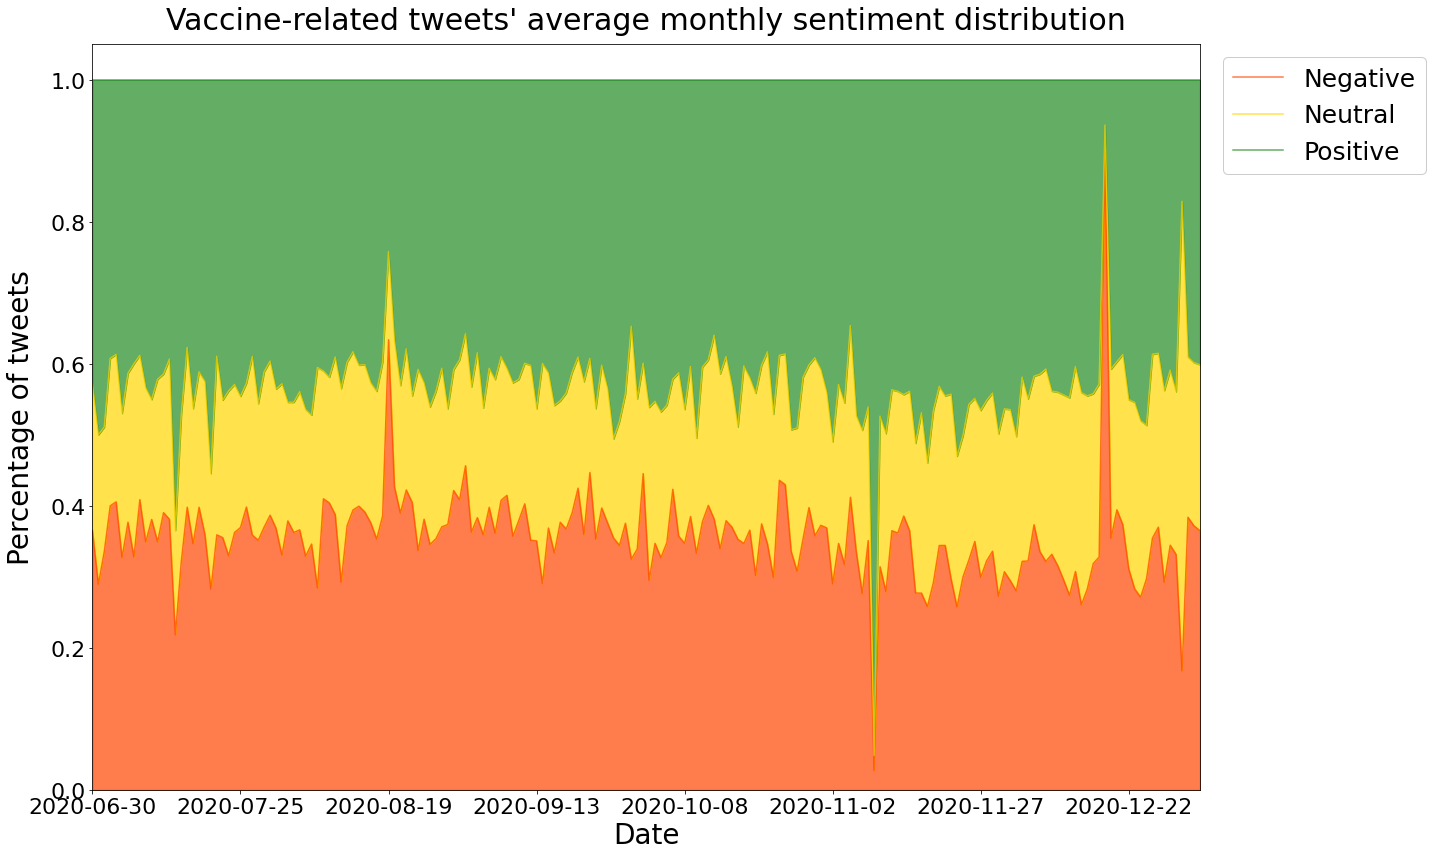

In [112]:
# proportion of sentiment by date
sent_by_day = topics.groupby('date')['sentiment'].value_counts(normalize=True).unstack()

# plot a stacked line graph
p1 = sent_by_day.plot.area(stacked=True, figsize=(20,12),
                           color=['orangered', 'gold', 'forestgreen'], alpha=0.7)

# prettify the graph
p1.set_title("Vaccine-related tweets' average monthly sentiment distribution", fontsize=30, pad=15)
p1.set_xlabel('Date', fontsize=28)
p1.set_ylabel('Percentage of tweets', fontsize=28, labelpad=15)
p1.legend(['Negative', 'Neutral', 'Positive'], facecolor='white', framealpha=1,
          bbox_to_anchor=(1.01, 1.0), fontsize=25)
plt.setp(p1.get_xticklabels(), fontsize=22)
plt.setp(p1.get_yticklabels(), fontsize=22);

# prepare to save and display
plt.tight_layout()
# # uncomment to save
plt.savefig('charts/sentiment_stacked_line_day.png', bbox_inches='tight', transparent=True)

plt.show()

In [93]:
start_date = "2020-11-1"
end_date = "2020-11-25"

after_start_date = topics["date"] >= start_date
before_end_date = topics["date"] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = topics.loc[between_two_dates]

print(filtered_dates)

              date  year  month month_year  \
219640  2020-11-25  2020     11    2020-11   
219641  2020-11-25  2020     11    2020-11   
219642  2020-11-25  2020     11    2020-11   
219643  2020-11-25  2020     11    2020-11   
219644  2020-11-25  2020     11    2020-11   
219645  2020-11-25  2020     11    2020-11   
219646  2020-11-25  2020     11    2020-11   
219647  2020-11-25  2020     11    2020-11   
219648  2020-11-25  2020     11    2020-11   
219649  2020-11-25  2020     11    2020-11   
219650  2020-11-25  2020     11    2020-11   
219651  2020-11-25  2020     11    2020-11   
219652  2020-11-25  2020     11    2020-11   
219653  2020-11-25  2020     11    2020-11   
219654  2020-11-25  2020     11    2020-11   
219655  2020-11-25  2020     11    2020-11   
219656  2020-11-25  2020     11    2020-11   
219657  2020-11-25  2020     11    2020-11   
219658  2020-11-25  2020     11    2020-11   
219659  2020-11-25  2020     11    2020-11   
219660  2020-11-25  2020     11   

In [94]:
filtered_dates

,date,year,month,month_year,tweet,sentiment_score,sentiment,tweet_clean,lda_topic_max
219640,2020-11-25,2020,11,2020-11,@FuriousIger @EPCATDork Do you know you got th...,0.0000,neutral,furiousiger epcatdork know get vaccine not pla...,1
219641,2020-11-25,2020,11,2020-11,"Social distancing Women...Ladies, I’m single ...",0.7845,positive,social distance woman lady single available bt...,16
219642,2020-11-25,2020,11,2020-11,@WBrettWilson @GeraldKutney Glad to hear that ...,0.7947,positive,wbrettwilson geraldkutney glad hear alarmist c...,9
219643,2020-11-25,2020,11,2020-11,@WinterSnoWolf I have seen the effects of this...,-0.5267,negative,wintersnowolf see effect virus people close no...,12
219644,2020-11-25,2020,11,2020-11,It’s sad seeing so many people being so anti-s...,-0.6845,negative,sad seeing many people anti science like not v...,12
219645,2020-11-25,2020,11,2020-11,It’s amazing how many people will defend and s...,0.9468,positive,amazing many people defend support pedophile s...,0
219646,2020-11-25,2020,11,2020-11,"@Veezy_JNR @GregStohr Just like a vaccine, it ...",-0.4515,negative,veezy_jnr gregstohr like vaccine still take mo...,1
219647,2020-11-25,2020,11,2020-11,Thread by @ASlavitt: COVID Update November 25:...,0.6597,positive,thread aslavitt covid update november take vac...,9
219648,2020-11-25,2020,11,2020-11,@fudgetosser @FinancialTimes Anyone that does ...,0.4019,positive,fudgetosser financialtime anyone research know...,0
219649,2020-11-25,2020,11,2020-11,a vaccine... please,0.3182,positive,vaccine please,10


In [95]:
start_date = "2020-12-10"
end_date = "2020-12-20"

after_start_date = topics["date"] >= start_date
before_end_date = topics["date"] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = topics.loc[between_two_dates]

print(filtered_dates)

              date  year  month month_year  \
163447  2020-12-20  2020     12    2020-12   
163448  2020-12-20  2020     12    2020-12   
163449  2020-12-20  2020     12    2020-12   
163450  2020-12-20  2020     12    2020-12   
163451  2020-12-20  2020     12    2020-12   
163452  2020-12-20  2020     12    2020-12   
163453  2020-12-20  2020     12    2020-12   
163454  2020-12-20  2020     12    2020-12   
163455  2020-12-20  2020     12    2020-12   
163456  2020-12-20  2020     12    2020-12   
163457  2020-12-20  2020     12    2020-12   
163458  2020-12-20  2020     12    2020-12   
163459  2020-12-20  2020     12    2020-12   
163460  2020-12-20  2020     12    2020-12   
163461  2020-12-20  2020     12    2020-12   
163462  2020-12-20  2020     12    2020-12   
163463  2020-12-20  2020     12    2020-12   
163464  2020-12-20  2020     12    2020-12   
163465  2020-12-20  2020     12    2020-12   
163466  2020-12-20  2020     12    2020-12   
163467  2020-12-20  2020     12   

In [96]:
filtered_dates

,date,year,month,month_year,tweet,sentiment_score,sentiment,tweet_clean,lda_topic_max
163447,2020-12-20,2020,12,2020-12,This vaccine shit is bullshit but if niggas ca...,-0.4404,negative,vaccine shit bullshit niggas go back attend br...,1
163448,2020-12-20,2020,12,2020-12,Fantastic explanation as to why the Pfizer vac...,0.5574,positive,fantastic explanation pfizer vaccine not cause...,12
163449,2020-12-20,2020,12,2020-12,Why aren’t teachers on the top priority list w...,0.3400,positive,not teacher top priority list come new vaccine...,9
163450,2020-12-20,2020,12,2020-12,@Julie32858882 @lyne_ian @RobertKennedyJr It s...,-0.3802,negative,julie lyne_ian robertkennedyjr soon require ma...,15
163451,2020-12-20,2020,12,2020-12,AOC (31 years old) getting the vaccine ahead o...,-0.5719,negative,aoc year old get vaccine ahead elder grave ris...,11
163452,2020-12-20,2020,12,2020-12,Some people really out here going to parties o...,0.7579,positive,people really go party ppl bar stuff like wait...,1
163453,2020-12-20,2020,12,2020-12,The fact that *all* politicians (&amp; their f...,-0.3875,negative,fact politician family get vaccine first wheth...,11
163454,2020-12-20,2020,12,2020-12,No politician should receive vaccine until eve...,-0.4724,negative,no politician receive vaccine every person wor...,16
163455,2020-12-20,2020,12,2020-12,US frontline essential workers and people over...,0.2023,positive,us frontline essential worker people recommend...,16
163456,2020-12-20,2020,12,2020-12,Can’t wait to get the vaccine so I can push ki...,-0.5423,negative,not wait get vaccine push kid bad boy https co...,9


/Users/ariadnavargas/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


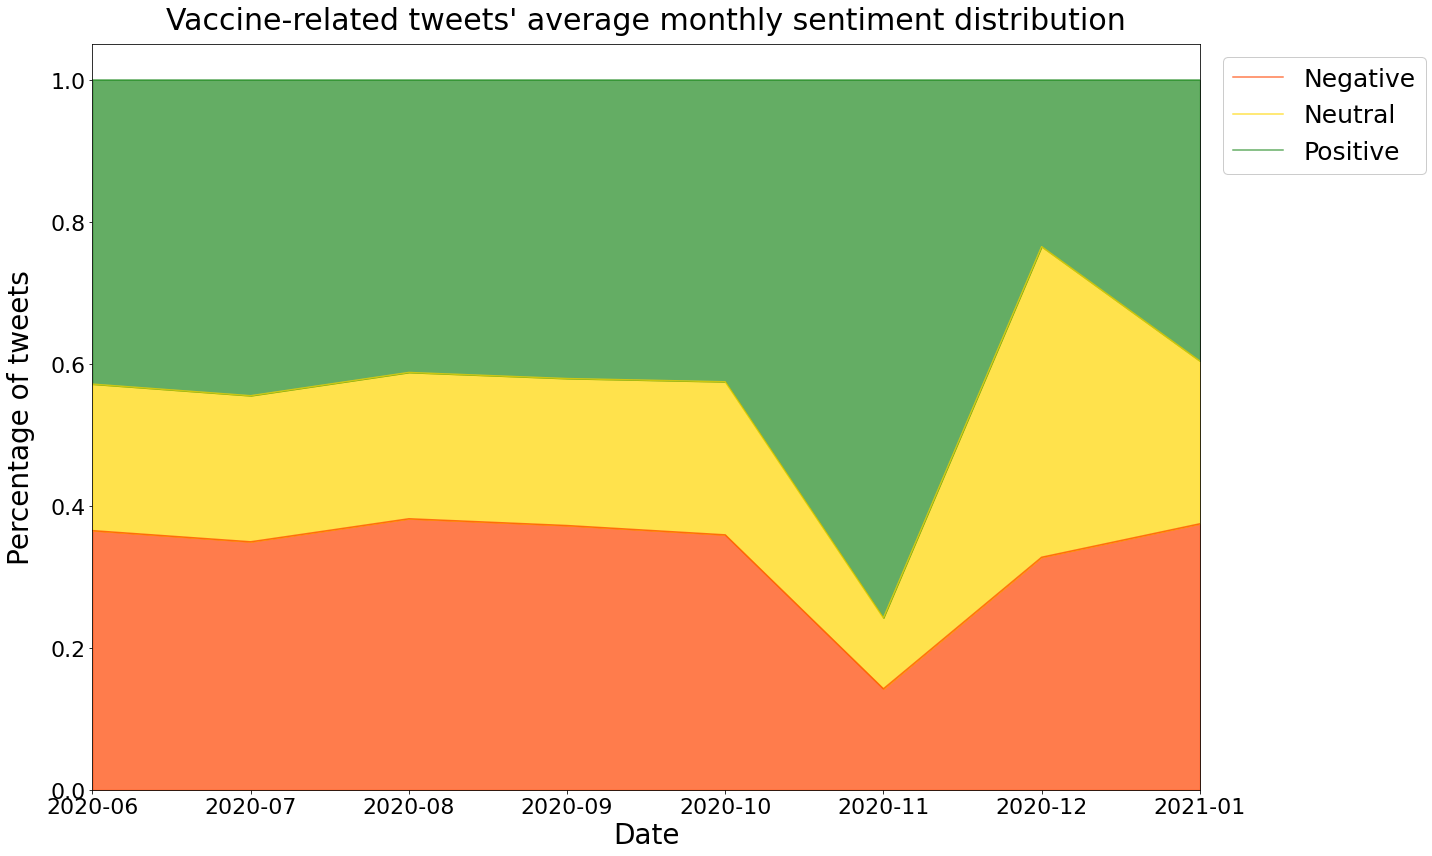

In [111]:
# proportion of sentiment by date
sent_by_day = topics.groupby('month_year')['sentiment'].value_counts(normalize=True).unstack()

# plot a stacked line graph
p1 = sent_by_day.plot.area(stacked=True, figsize=(20,12),
                           color=['orangered', 'gold', 'forestgreen'], alpha=0.7)

# prettify the graph
p1.set_title("Vaccine-related tweets' average monthly sentiment distribution", fontsize=30, pad=15)
p1.set_xlabel('Date', fontsize=28)
p1.set_ylabel('Percentage of tweets', fontsize=28, labelpad=15)
p1.legend(['Negative', 'Neutral', 'Positive'], facecolor='white', framealpha=1,
          bbox_to_anchor=(1.01, 1.0), fontsize=25)
plt.setp(p1.get_xticklabels(), fontsize=22)
plt.setp(p1.get_yticklabels(), fontsize=22);

# prepare to save and display
plt.tight_layout()
# # uncomment to save
plt.savefig('charts/sentiment_stacked_line_mnth.png', bbox_inches='tight', transparent=True)

plt.show()

In [98]:
# look at the distribution of sentiment
topics.groupby('month_year').sentiment.value_counts(normalize=True)

month_year  sentiment
2020-06     positive     0.428571
            negative     0.365079
            neutral      0.206349
2020-07     positive     0.444891
            negative     0.349358
            neutral      0.205751
2020-08     positive     0.412137
            negative     0.381795
            neutral      0.206068
2020-09     positive     0.420724
            negative     0.372250
            neutral      0.207026
2020-10     positive     0.425236
            negative     0.359125
            neutral      0.215640
2020-11     positive     0.757977
            negative     0.142252
            neutral      0.099771
2020-12     neutral      0.437507
            negative     0.327572
            positive     0.234920
2021-01     positive     0.396020
            negative     0.374699
            neutral      0.229281
Name: sentiment, dtype: float64

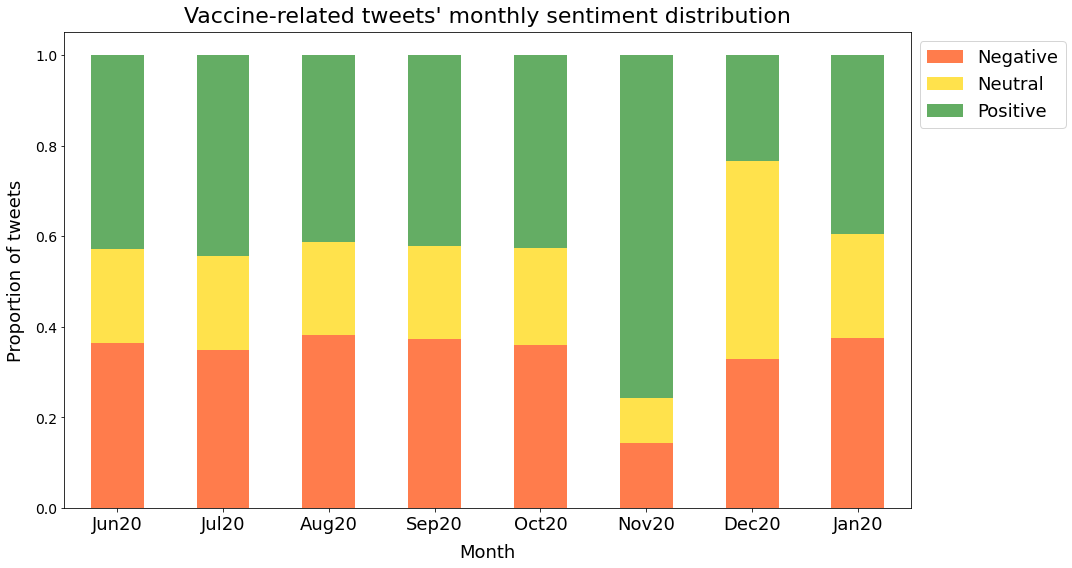

In [110]:
# prepare data for stacked bar
month_sentiment = topics.groupby('month_year').sentiment.value_counts(normalize=True).unstack()

# plot stacked bar graph
p3 = month_sentiment.plot(kind='bar', stacked=True, figsize=(15,8),
                           color=['orangered', 'gold', 'forestgreen'], alpha=0.7, fontsize=14)

# prettify the graph
p3.set_title("Vaccine-related tweets' monthly sentiment distribution", fontsize=22, pad=10)
p3.set_xlabel('Month', fontsize=18, labelpad=10)
p3.set_xticklabels(['Jun20', 'Jul20', 'Aug20', 'Sep20', 'Oct20', 'Nov20', 'Dec20', 'Jan20'], rotation='horizontal', fontsize=18)
p3.set_ylabel('Proportion of tweets', fontsize=18, labelpad=10)
p3.legend(['Negative', 'Neutral', 'Positive'], fontsize=18, bbox_to_anchor=(1,1))

# prepare to save and display
plt.tight_layout()
# # uncomment to save
plt.savefig('charts/sentiment_month_barstack.png', bbox_inches='tight', transparent=True)

plt.show()

## Sentiment distribution by topic

/Users/ariadnavargas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


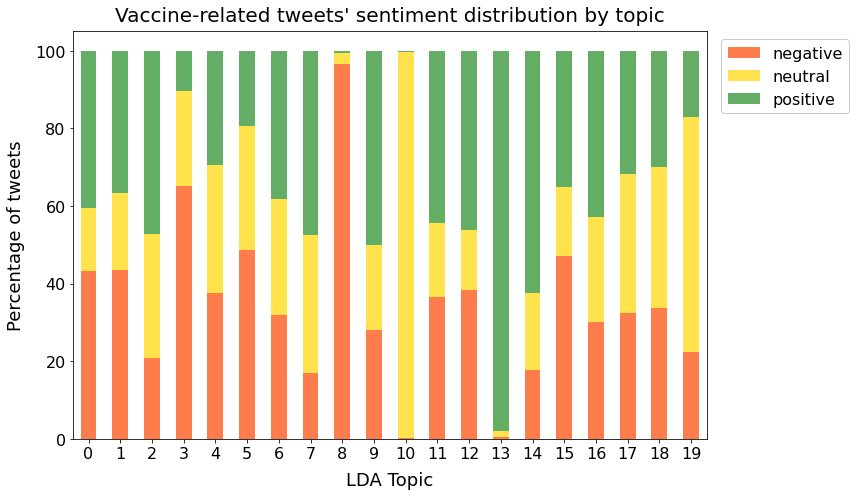

In [113]:
# sort by percentage of topics 
days = topics.groupby('lda_topic_max').sentiment.value_counts(normalize=True).unstack()

# plot a stacked bar graph
p7 = days.plot(kind='bar', stacked=True, figsize=(12,7), color=['orangered', 'gold', 'forestgreen'],
               alpha=0.7, fontsize=16)

# prettify the chart
p7.set_title("Vaccine-related tweets' sentiment distribution by topic", fontsize=20, pad=10)
p7.set_xlabel('LDA Topic', fontsize=18, labelpad=10)
p7.set_ylabel('Percentage of tweets', fontsize=18, labelpad=10)
p7.set_xticklabels(range(20), rotation=0, fontsize=16)
p7.set_yticklabels(range(0,101,20), fontsize=16)
p7.legend(['negative', 'neutral', 'positive'], facecolor='white', framealpha=1,
          bbox_to_anchor=(1.01, 1.0), fontsize=16)

# prepare to save and display
plt.tight_layout()
# # uncomment to save 
plt.savefig('charts/sentiment_topics_barstack.png', bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
topics_dum= 